In [16]:
import torch
from transformers import RobertaForMultipleChoice
import logging
logging.basicConfig(level=logging.INFO)
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [17]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
print("We are using the device %s - %s" % (device, device_name))
model_name = "../../roberta-large"
learning_rate = 1.5e-5
batch_size = 24
epoch = 8
optimizer_name = 'Adam'

We are using the device cuda:2 - GeForce RTX 2080 Ti


In [18]:
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Sentence 0', 'Sentence 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])['Answer']
    return texts, labels

In [19]:
train_texts, train_labels = get_info_from_csv(
    '../../DataSet/Training Data/subtaskA_data_all.csv',
    '../../DataSet/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../../DataSet/Dev Data/subtaskA_dev_data.csv',
    '../../DataSet/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../../DataSet/Test Data/subtaskA_test_data.csv',
    '../../DataSet/Test Data/subtaskA_gold_answers.csv'
)


In [20]:
question = "If the following statement is in common sense ?"
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast,AdamW

def get_tokenizer(model_name):
    if model_name.startswith("bert"):
        return BertTokenizerFast.from_pretrained(model_name)
    if model_name.startswith("distilbert"):
        return DistilBertTokenizerFast.from_pretrained(model_name)
    if model_name.startswith("roberta"):
        return RobertaTokenizerFast.from_pretrained(model_name)
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)


train_encodings = tokenizer([question] * 2 * len(train_texts),   
                            sum([train_texts.iloc[i, 1:].tolist() for i in range(len(train_texts))], start=[]), 
                            return_tensors="pt", 
                            padding=True)
train_encodings = {key: value.view(len(train_texts), 2, -1) for key, value in train_encodings.items()}

val_encodings = tokenizer([question] * 2 * len(val_texts),   
                            sum([val_texts.iloc[i, 1:].tolist() for i in range(len(val_texts))], start=[]), 
                            return_tensors="pt", 
                            padding=True)
val_encodings = {key: value.view(len(val_texts), 2, -1) for key, value in val_encodings.items()}

test_encodings = tokenizer([question] * 2 * len(test_texts),   
                            sum([test_texts.iloc[i, 1:].tolist() for i in range(len(test_texts))], start=[]), 
                            return_tensors="pt", 
                            padding=True)
test_encodings = {key: value.view(len(test_texts), 2, -1) for key, value in test_encodings.items()}

In [21]:
class ComVEDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [22]:
train_dataset = ComVEDataset(train_encodings, train_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)
val_dataset = ComVEDataset(val_encodings, val_labels)

In [23]:
del test_encodings
del train_encodings
del val_encodings
del train_labels
del test_labels
del val_labels
torch.cuda.empty_cache()

In [24]:
model = RobertaForMultipleChoice.from_pretrained(model_name).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at ../../roberta-large were not used when initializing RobertaForMultipleChoice: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at ../../roberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to us

In [25]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions
# Loading the optimizer
if optimizer_name == "Adam":
    optim = AdamW(model.parameters(), lr=learning_rate)

/root/miniconda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def validate(model):

    # Get test data by DataLoader
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    # Start testing
    model.eval()

    with torch.no_grad():
        
        correct = 0
        count = 0
        record = list()
        
        pbar = tqdm(val_loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            
            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'loss': '{:.3f}'.format(loss.item()),
                'accuracy': '{:.3f}'.format(accuracy)
            })
        
            # record the results
            record.append((int(labels),int(predictions)))
            
        pbar.close()
    time.sleep(0.3)
    print("The final accuracy on the validate dataset: %s%%" % round(accuracy*100,4))
    return round(accuracy*100,4)

In [27]:
# Training
from torch.utils.data import DataLoader
import time
# Set the number of epoch
epoch = epoch

# Get training data by DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Start training
model.train()

train_loss = list()
train_accuracies = list()
highest_accuracy = 0
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)
    val_accuracy=validate(model)
    
    # save the model with the highest accuracy
    if highest_accuracy <= val_accuracy:
        highest_accuracy = val_accuracy
    torch.save(model.state_dict(), "./Subtask_A_"+str(epoch_i)+"_Model.pth")

Epoch 1/8


  0%|          | 0/417 [00:00<?, ?it/s]/tmp/ipykernel_375/3522555481.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 997/997 [00:33<00:00, 30.17it/s, loss=0.000, accuracy=0.933]


The final accuracy on the validate dataset: 93.2798%
Epoch 2/8


100%|██████████| 997/997 [00:33<00:00, 30.02it/s, loss=0.000, accuracy=0.932]


The final accuracy on the validate dataset: 93.1795%
Epoch 3/8


100%|██████████| 997/997 [00:32<00:00, 30.25it/s, loss=0.000, accuracy=0.945]


The final accuracy on the validate dataset: 94.4835%
Epoch 4/8


100%|██████████| 997/997 [00:33<00:00, 29.89it/s, loss=0.000, accuracy=0.948]


The final accuracy on the validate dataset: 94.7844%
Epoch 5/8


100%|██████████| 997/997 [00:32<00:00, 31.13it/s, loss=0.000, accuracy=0.949]


The final accuracy on the validate dataset: 94.8847%
Epoch 6/8


100%|██████████| 997/997 [00:32<00:00, 30.31it/s, loss=0.000, accuracy=0.945] 


The final accuracy on the validate dataset: 94.4835%
Epoch 7/8


100%|██████████| 997/997 [00:31<00:00, 31.77it/s, loss=0.000, accuracy=0.946] 


The final accuracy on the validate dataset: 94.5838%
Epoch 8/8


100%|██████████| 997/997 [00:34<00:00, 29.13it/s, loss=0.000, accuracy=0.946] 


The final accuracy on the validate dataset: 94.5838%


In [28]:
import time

def Test(model_params_path):   # Testing

    # Load the best-trained model
    model.load_state_dict(torch.load(model_params_path))

    # Get test data by DataLoader
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Start testing
    model.eval()

    with torch.no_grad():
        
        correct = 0
        count = 0
        record = list()
        
        pbar = tqdm(test_loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            
            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'loss': '{:.3f}'.format(loss.item()),
                'accuracy': '{:.3f}'.format(accuracy)
            })
        
            # record the results
            record.append((int(labels),int(predictions)))
        
        pbar.close()
    
    time.sleep(0.3)
    print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))
    
for epoch_i in range(epoch):
    print("epoch: ", epoch_i)
    Test("./Subtask_A_"+str( epoch_i)+"_Model.pth")

epoch:  0


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_375/3522555481.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 1000/1000 [00:38<00:00, 26.03it/s, loss=0.001, accuracy=0.906]


The final accuracy on the test dataset: 90.6%
epoch:  1


100%|██████████| 1000/1000 [00:32<00:00, 30.78it/s, loss=0.000, accuracy=0.926]


The final accuracy on the test dataset: 92.6%
epoch:  2


100%|██████████| 1000/1000 [00:33<00:00, 30.11it/s, loss=0.000, accuracy=0.938]


The final accuracy on the test dataset: 93.8%
epoch:  3


100%|██████████| 1000/1000 [00:32<00:00, 31.00it/s, loss=0.000, accuracy=0.942]


The final accuracy on the test dataset: 94.2%
epoch:  4


100%|██████████| 1000/1000 [00:31<00:00, 31.59it/s, loss=0.000, accuracy=0.937]


The final accuracy on the test dataset: 93.7%
epoch:  5


100%|██████████| 1000/1000 [00:32<00:00, 31.18it/s, loss=0.000, accuracy=0.934]


The final accuracy on the test dataset: 93.4%
epoch:  6


100%|██████████| 1000/1000 [00:32<00:00, 30.90it/s, loss=0.000, accuracy=0.936]


The final accuracy on the test dataset: 93.6%
epoch:  7


100%|██████████| 1000/1000 [00:32<00:00, 31.06it/s, loss=0.000, accuracy=0.937]


The final accuracy on the test dataset: 93.7%


In [29]:
torch.cuda.empty_cache()

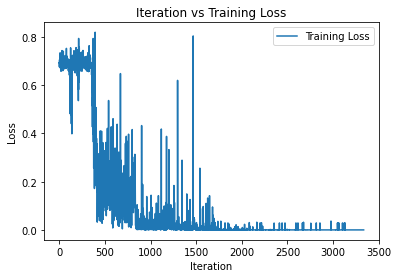

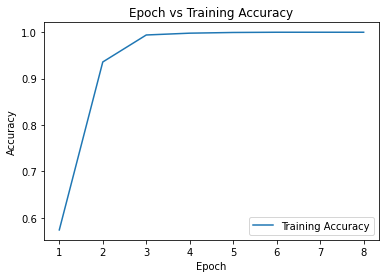

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()